<a href="https://colab.research.google.com/github/dyna-bytes/PyTorchIntensive/blob/main/3_4_2_CNN_Feature_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'[{_str}]:')
        _str = ''
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}')

In [ ]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics torchviz

## Import Module

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
#from pytorch_lightning.core.lightning import LightningModule
from torchmetrics import functional as FM
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import CSVLogger
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.5]

device ='cuda:0'
torch.__version__

'2.0.1+cu118'

# 실습 : CNN Feature Maps

## **DataSet**

In [ ]:
from torchvision.datasets import FashionMNIST, MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

noise_on = False
fashion_mnist = False
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
])

epochs=10
batch_size=1024

download_root = './MNIST'
train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

trainDataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valDataLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 93718988.15it/s]


Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23691706.20it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26797575.15it/s]


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22386050.26it/s]


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



## **Model**

#### Model define

In [ ]:
loss_function = nn.CrossEntropyLoss()

class CNN_BN2(pl.LightningModule):
    def __init__(self):
        super(CNN_BN2, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64*3*3, 256),
            nn.Linear(256, 10))

    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model_BN2 = CNN_BN2()
summary(model_BN2, input_size=(8, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_BN2                                  [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Conv2d: 2-1                       [8, 64, 28, 28]           640
│    └─BatchNorm2d: 2-2                  [8, 64, 28, 28]           128
│    └─ReLU: 2-3                         [8, 64, 28, 28]           --
│    └─MaxPool2d: 2-4                    [8, 64, 14, 14]           --
│    └─Conv2d: 2-5                       [8, 64, 14, 14]           36,928
│    └─BatchNorm2d: 2-6                  [8, 64, 14, 14]           128
│    └─ReLU: 2-7                         [8, 64, 14, 14]           --
│    └─MaxPool2d: 2-8                    [8, 64, 7, 7]             --
│    └─Conv2d: 2-9                       [8, 64, 7, 7]             36,928
│    └─BatchNorm2d: 2-10                 [8, 64, 7, 7]             128
│    └─ReLU: 2-11                        [8, 64, 7, 7]             --
│  

#### Fit

In [ ]:
%%time
model_BN2 = CNN_BN2()
epochs = 5
name = "cnn_batchnorm2"
logger = CSVLogger("logs", name=name)
trainer = Trainer(max_epochs=epochs, logger=logger, accelerator='auto')
trainer.fit(model_BN2, trainDataLoader, val_dataloaders=valDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 225 K 
--------------------------------------
225 K     Trainable params
0         Non-trainable params
225 K     Total params
0.901     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


CPU times: user 1min 1s, sys: 388 ms, total: 1min 2s
Wall time: 1min 11s


CPU times: user 1min 7s, sys: 372 ms, total: 1min 7s
Wall time: 1min 7s

## Filter Plotting

In [ ]:
model_BN2

CNN_BN2(
  (layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=576, out_features=256, bias=True)
    (14): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [ ]:
!pip3 install onnx
torch.onnx.export(model_BN2, torch.zeros(8, 1, 28, 28), 'model_BN2.onnx')
# torch.onnx.export(model_BN2, torch.zeros(8, 1, 28, 28).to(device), 'model_BN2.onnx')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 72.2 MB/s eta 0:00:00
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



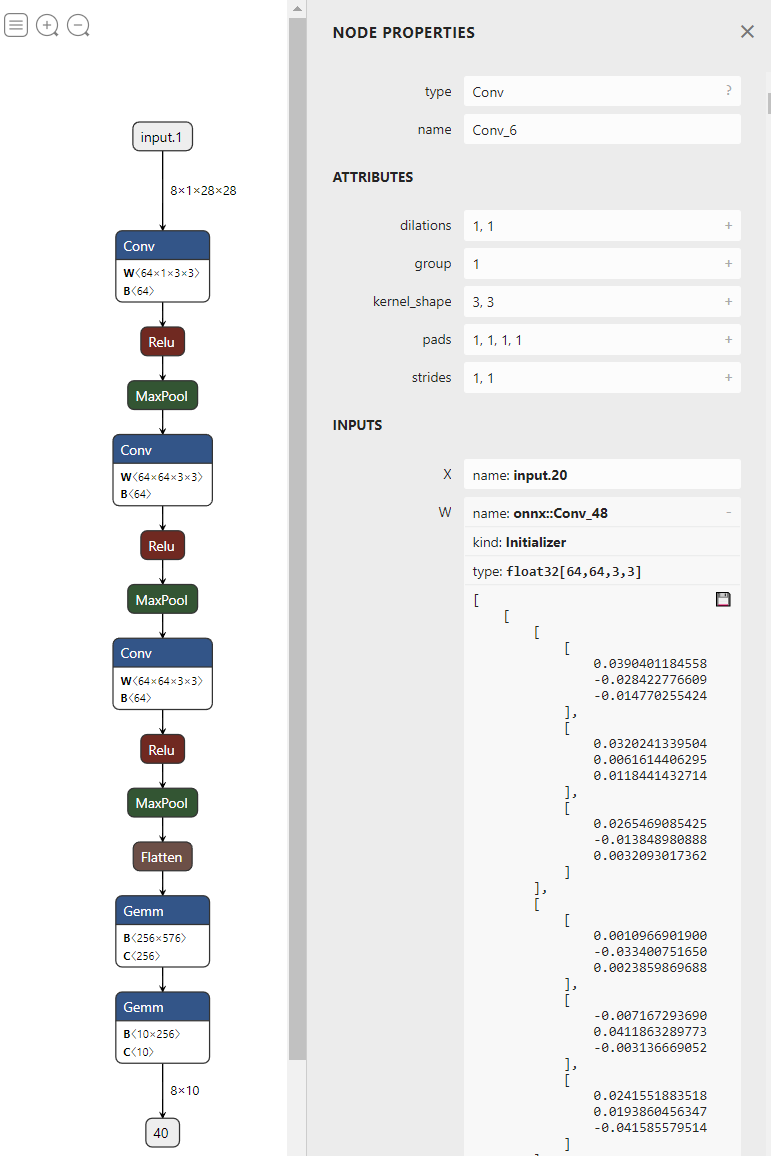

In [ ]:
ps(model_BN2.layers[0].weight)
model_BN2.layers[0].__class__

[] Shapetorch.Size([64, 1, 3, 3])


torch.nn.modules.conv.Conv2d

In [ ]:
# summarize filter shapes
filter_list = []
for i, layer in enumerate(model_BN2.layers):
    # check for convolutional layer
    if 'Conv' not in str(layer.__class__):
        continue #'conv'가 포함되지 않으면 skip
    # get filter weights
    filters = layer.weight
    filter_list.append(filters) #use_bias=False
    print(f'[{i}]th layer:{layer.__class__}  {filters.shape}')

[0]th layer:<class 'torch.nn.modules.conv.Conv2d'>  torch.Size([64, 1, 3, 3])
[4]th layer:<class 'torch.nn.modules.conv.Conv2d'>  torch.Size([64, 64, 3, 3])
[8]th layer:<class 'torch.nn.modules.conv.Conv2d'>  torch.Size([64, 64, 3, 3])


In [ ]:
# plot n x n images
def square(imgs, n):
    img_num = n
    plt.figure(figsize=(6,6))
    print(f'min[{np.min(imgs):2.2f}],max[{np.max(imgs):2.2f}]')
    f_min, f_max = imgs.min(), imgs.max() #(3,3,64,64)
    imgs = (imgs - f_min) / (f_max - f_min)
    for i in range(n):
        for j in range(n):
            p_num = i*n + j
            ax = plt.subplot(n, n, p_num+1)#(row,col,index)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(imgs[p_num, :, :], cmap='gray')
    plt.show()

* 첫번째 conv layer filter

In [ ]:
filters[:,0,:,:].shape # 입력채널을 향한 64 node의 weight

torch.Size([64, 3, 3])

torch.Size([64, 3, 3])
min[-0.37],max[0.35]


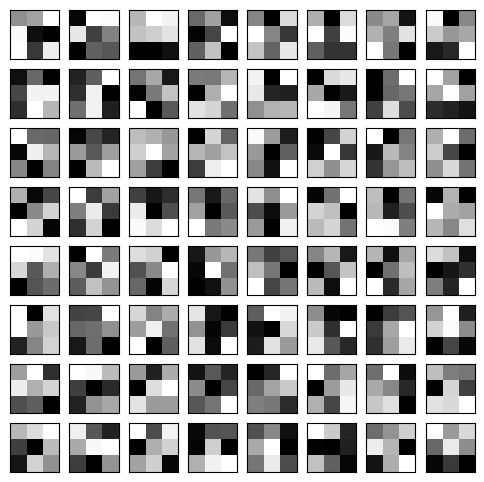

In [ ]:
filters = filter_list[0]
# in_0, out_all
print(filters[:,0,:,:].shape)   #(out_ch,in_cn,3,3)
square(filters[:,0,:,:].cpu().detach().numpy(), 8)

* 두번째 conv layer filter

[] Shape(64, 3, 3)
min[-0.06],max[0.06]


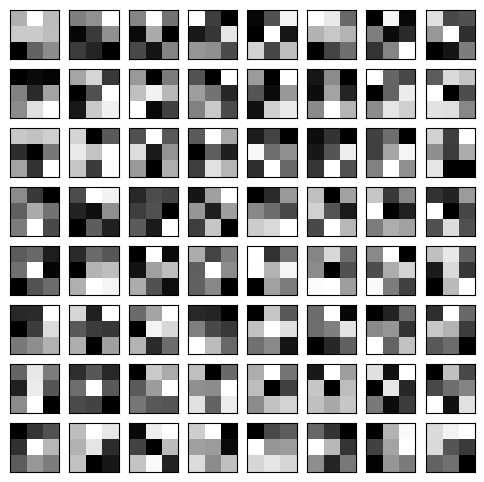

In [ ]:
filters = filter_list[1] #(out_ch,in_cn,3,3)
# in_0,out_all
ps(filters[0,:,:,:].cpu().detach().numpy())
square(filters[0,:,:,:].cpu().detach().numpy(), 8)

* 세번째 conv layer filter

torch.Size([64, 3, 3])
min[-0.06],max[0.07]


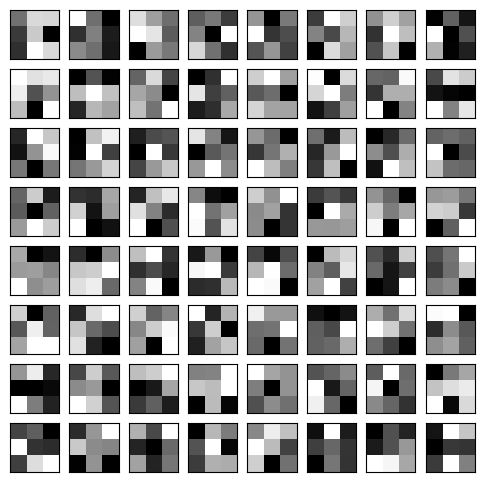

In [ ]:
filters = filter_list[2]
# in_0, out_all
print(filters[0,:,:,:].shape) #(out_ch,in_cn,3,3)
square(filters[0,:,:,:].cpu().detach().numpy(), 8)

### Feature map extract model define

In [ ]:
#model_BN_FM
model_BN2

CNN_BN2(
  (layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=576, out_features=256, bias=True)
    (14): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [ ]:
# conv layer 위치 확인
for i, layer in enumerate(model_BN2.layers):
    # check for convolutional layer
    if 'Conv' not in str(layer.__class__):
        continue #'conv'가 포함되지 않으면 skip
    # get filter weights
    filters = layer.weight
    print(f'[{i}]th layer:{layer.__class__}  {filters.shape}')

[0]th layer:<class 'torch.nn.modules.conv.Conv2d'>  torch.Size([64, 1, 3, 3])
[4]th layer:<class 'torch.nn.modules.conv.Conv2d'>  torch.Size([64, 64, 3, 3])
[8]th layer:<class 'torch.nn.modules.conv.Conv2d'>  torch.Size([64, 64, 3, 3])


In [ ]:
class CNN_BN_FM(CNN_BN2):
    def __init__(self):
        super(CNN_BN_FM, self).__init__()

    def forward(self, x):
        out1 = self.layers[0](x)
        out2 = self.layers[:5](x)
        out3 = self.layers[:9](x)
        return out1, out2, out3

model_BN_FM = CNN_BN_FM()
summary(model_BN_FM, input_size=(8, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_BN_FM                                [8, 64, 28, 28]           --
├─Sequential: 1-1                        --                        150,410
│    └─Conv2d: 2-1                       [8, 64, 28, 28]           640
│    └─Conv2d: 2-2                       [8, 64, 28, 28]           (recursive)
│    └─BatchNorm2d: 2-3                  [8, 64, 28, 28]           128
│    └─ReLU: 2-4                         [8, 64, 28, 28]           --
│    └─MaxPool2d: 2-5                    [8, 64, 14, 14]           --
│    └─Conv2d: 2-6                       [8, 64, 14, 14]           36,928
│    └─Conv2d: 2-7                       [8, 64, 28, 28]           (recursive)
│    └─BatchNorm2d: 2-8                  [8, 64, 28, 28]           (recursive)
│    └─ReLU: 2-9                         [8, 64, 28, 28]           --
│    └─MaxPool2d: 2-10                   [8, 64, 14, 14]           --
│    └─Conv2d: 2-11                      [8, 64

In [ ]:
#torch.onnx.export(model_BN_FM, torch.zeros(8, 1, 28, 28).to(device), 'model_BN_FM.onnx')

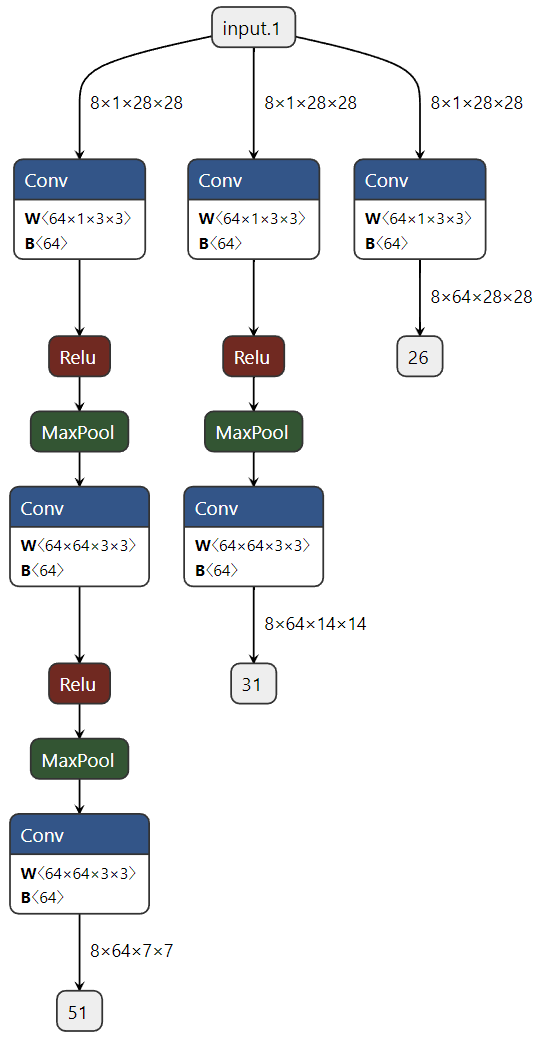

- Image ploting function

- Get feature maps : fm_model.predict( )

In [ ]:
test_dataset[0][0].shape # (image,index/label)

torch.Size([1, 28, 28])

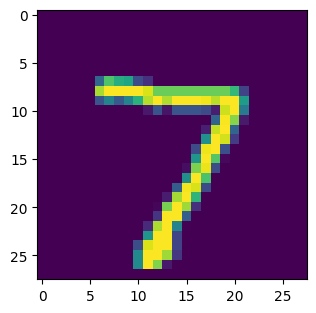

In [ ]:
plt.imshow(test_dataset[0][0][0])

In [ ]:
# Returns 3 items tuple(tensor, grad_fn)
n=0 # 첫번째 이미지를 넣고 추론하면서, feature를 반환 받음
#[(1,28,28,64),(1,14,14,64),(1,7,7,64)]
feature_maps = model_BN_FM(
    test_dataset[0][0].unsqueeze(dim=0).to(device)) #(1,1,28,28)<-(1,28,28)

In [ ]:
pst(feature_maps[0]) # torch.Tensor:(tensor,grad_fn)
pst(feature_maps[1])
pst(feature_maps[2])

[] Shapetorch.Size([1, 64, 28, 28]), <class 'torch.Tensor'>
[] Shapetorch.Size([1, 64, 14, 14]), <class 'torch.Tensor'>
[] Shapetorch.Size([1, 64, 7, 7]), <class 'torch.Tensor'>


#### Plot the feature maps

min[-1.46],max[1.27]


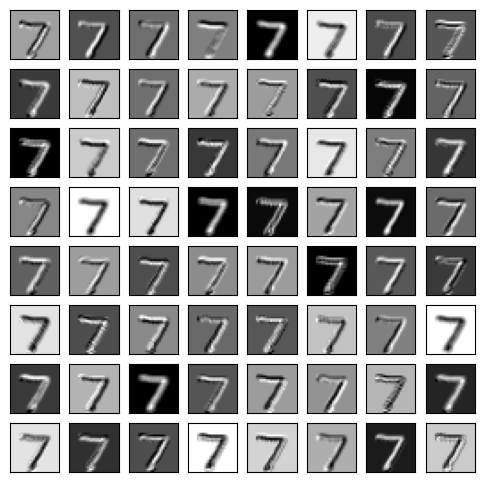

min[-3.28],max[3.26]


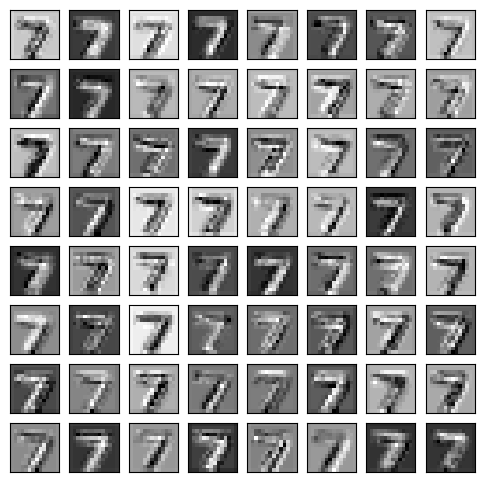

min[-2.95],max[2.56]


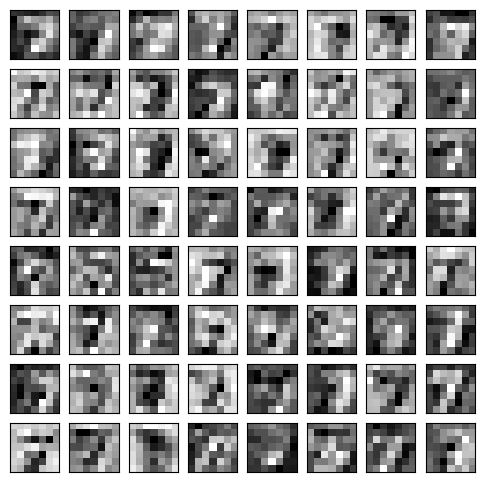

In [ ]:
# 3개의 레이어가 출력한 각64개의 feature map
for i, fmap in enumerate(feature_maps):
    square(fmap.cpu().detach().numpy()[0], 8)

## **실습 과제**

#### 과제 feature map을 관찰해 보자
##### -- MaxPooling layer 통과 전후의 feature map을 비교해보자
##### -- BatchNormalization layer 통과 전후의 feature map을 비교해 보자